In [92]:
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [93]:
#Configuring the IO structure:
W_size=3
st=4
et=22
Bin_size=1
prediction_size=1
n_features=54
irows=int(W_size/Bin_size)
icols=n_features
orows=int(prediction_size/Bin_size)
ocols=52
nipd=int((et-st)/Bin_size)-irows-orows+1

In [94]:
# Data Preparation
import pandas as pd

# Selecting data based on bin size
#if Bin_size==0.5:
#    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_30min_n&f.csv',header =None)
if Bin_size==1:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Final_Results/Data/from_R_M1_1Hr_Model123.csv',header =None)
    
#Converting dataframe into matrix    
dataset=df2.as_matrix()

/home/pennyworth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [95]:
#Checking if the import is good to go:
Nos=332
if len(dataset)-1==Nos*18/Bin_size:
    print("Import successful!")

Import successful!


In [96]:
def giveme_dataset(rows,cols):
    for i in range(1,rows+1):
        print(dataset[i][:cols])
giveme_dataset(4,3)

[0.08259227 0.01696887 0.02251618]
[0.00654287 0.0388456  0.04031916]
[0.00663925 0.11435217 0.05657526]
[0.10327419 0.09795866 0.09841556]


In [97]:
print(irows,orows)

3 1


In [98]:
# Dataset looks good here
def giveme_dataset(rows,cols):
    for i in range(1,rows+1):
        print(dataset[i][:cols])
giveme_dataset(3,3)

[0.08259227 0.01696887 0.02251618]
[0.00654287 0.0388456  0.04031916]
[0.00663925 0.11435217 0.05657526]


In [99]:
#Fixing number of clusters:
nclust=3

#Selecting correlated columns based on cluster number
if nclust==5:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Final_Results/Data/Tree_5branchseg_M1.csv',header =None)
if nclust==4:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Final_Results/Data/Tree_4branchseg_M1.csv',header =None)
if nclust==3:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Final_Results/Data/Tree_3branchseg_M1.csv',header =None)    
if nclust==2:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Final_Results/Data/Tree_2branchseg_M1.csv',header =None)
index_ps=df_clust[1]

#Creating a list of columns to consider for each model
cols2consider=[]
for i in range(nclust):
    cols2consider.append([])

#Appending values to cols2consider
for i in range(1,len(index_ps)):
    bloc=int(index_ps[i])
    cols2consider[bloc-1].append(i)
    
# Note: Here, in elements of cols2consider, segments start from 1 and go till 280.
# but while indexing in dataset, it should start from 0 therefore we subtract 1 
# from elements in cols2consider
c2c_copy=cols2consider
cols2consider=[]
for ar in c2c_copy:
    cols2consider.append([k-1 for k in ar])

if cols2consider[0]==[k-1 for k in c2c_copy[0]]:
    print("Unit Subraction from cols2consider complete! \n")
else:
    print("ERROR: Something wrong with subraction! \n")

#Check if everything is fine
index_l=index_ps.tolist()      # converting pandas series to list
if index_l.count('1')==len(cols2consider[0]) and (len(cols2consider[nclust-1])==index_l.count(str(nclust))):
    print("Good to go! Cols2consider seems good..")

Unit Subraction from cols2consider complete! 

Good to go! Cols2consider seems good..


In [100]:
len(cols2consider[0])+len(cols2consider[1])+len(cols2consider[2])#+len(cols2consider[3])

52

In [101]:
# Function to check a X,y pair and look at the lengths:
def verify_io(Xi,yi,info,i):
    if info==True:
        print("Number of X matrices:",len(Xi))
        print("Number of y matrices:",len(yi))
        print("Number i/o pairs expected:",(rows_pday-irows-orows+1)*332)
    elif(len(Xi)==len(yi)==(rows_pday-irows-orows+1)*332):
        print("Number of i/o pairs is as expected!")
    else:
        print("ERROR: Number of i/o pairs is not as expected!")
    if info==True:
        print("Number of features in each X matrix:",len(Xi[0][1]))
        print("Number of features in each y matrix:",len(yi[0]))
        print("Number of features expected:",len(cols2consider[i])+2,"for X")
    elif(len(Xi[0][1])-2==len(yi[0])==len(cols2consider[i])):
        print("Number of features is as expected!")
    else:
        print("ERROR: Number of features is not as expected!")

In [102]:
# multivariate multi-step data preparation
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Create a list of X and y to put in X and y for different groups.
yl=[]
for i in range(nclust):
    yl.append([])
Xl=[]
for i in range(nclust):
    Xl.append([])

#Split sequences according to group number given:
def split_sequences_by_grp(sequences, n_steps_in, n_steps_out,grp_no): # Grp no should start from 0
    for i in range(len(sequences)):
        # Find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # Check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # Select columns depending on grouping and adding Weekday and Hour data
        ysel_col=[ji for ji in cols2consider[grp_no]]
        Xsel_col=[ja for ja in cols2consider[grp_no]]
        Xsel_col.append(52)
        Xsel_col.append(53)
        #print("Xsel_col=",Xsel_col)
        #print("ysel_col=",ysel_col)
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix,Xsel_col], sequences[end_ix:out_end_ix,ysel_col][0]
        #print("Seq_x",seq_x)
        #print("Seq_y",seq_y)
        Xl[grp_no].append(seq_x)
        yl[grp_no].append(seq_y)
    if len(seq_x[0])!= len(seq_y)+2:
        print("ERROR: column selection wrong!")
    return None

n_steps_in, n_steps_out = int(irows), int(orows)
rows_pday=int((et-st)/Bin_size)

# Convert into input/output
# Need to change to 34 or 35 or whatever when nrows in dataset change
#i=1
for i in range(1,Nos+1):
    todays_df=dataset[(i-1)*rows_pday+1:i*rows_pday+1]
    for j in range(nclust):
         #print("\n\nFor group:",j)
# k=np.asarray([i for i in range(1,100*20+1)])
# k1=k.reshape(20,100)
        split_sequences_by_grp(todays_df, n_steps_in, n_steps_out,j)


In [103]:
#This
yl[0][2]

array([0.0538049 , 0.12850689, 0.2091169 , 0.04657286, 0.05951147,
       0.14287017, 0.14362834, 0.38072775, 0.57535064, 0.13706335,
       0.31931275, 0.4025251 , 0.26288731, 0.12827641, 0.20163038,
       0.31266037, 0.19588775])

In [104]:
#Check if the matrix are created properly:
verify_io(Xl[0],yl[0],True,0)
verify_io(Xl[1],yl[1],False,1)
verify_io(Xl[2],yl[2],False,2)
#verify_io(Xl[3],yl[3],False,3)

Number of X matrices: 4980
Number of y matrices: 4980
Number i/o pairs expected: 4980
Number of features in each X matrix: 19
Number of features in each y matrix: 17
Number of features expected: 19 for X
Number of i/o pairs is as expected!
Number of features is as expected!
Number of i/o pairs is as expected!
Number of features is as expected!


In [105]:
def giveme_y(rows,cols):
    for i in range(0,rows+1):
        print(yl[0][i][:cols])
giveme_y(3,3)

[0.10327419 0.09795866 0.09841556]
[0.02636669 0.19792282 0.08418935]
[0.0538049  0.12850689 0.2091169 ]
[0.14940848 0.27323049 0.37205773]


In [106]:
irows,orows

(3, 1)

In [107]:
#Filtering the Na IO matrices out
from math import isnan
import numpy as np

# #Function to check if all the NA matrices are deleted.
def check_NA(X_fil,y_fil,Name):
    Na_count=0
    for i in range(len(X_fil)):
        if np.any(np.isnan(y_fil[i]))==True & np.any(np.isnan(X_fil[i]))==True:
            Na_count=Na_count+1
    if Na_count==0:
        print("Na Matrices filtered out sucessfuly in",Name,"!")
    else:
        print("ERROR: NA value found!")
        
#Function to filter the NA matrices.
def filter_NA(X_o,y_o):
    X_fil=np.array(X_o)
    y_fil=np.array(y_o)
    del_index=[]
    # Noting down the index of Na matrices in del_index 
    for i in range(len(X_fil)):
        del_index.append(np.any(np.isnan(X_fil[i])) or np.any(np.isnan(y_fil[i])))
    # Filtering out the Na matrices from y_fil and X_fil by indexing using a list
    y_fil=y_fil[list(~np.array(del_index))]
    X_fil=X_fil[list(~np.array(del_index))]
    return X_fil,y_fil

X1,y1=filter_NA(Xl[0],yl[0])
X2,y2=filter_NA(Xl[1],yl[1])
X3,y3=filter_NA(Xl[2],yl[2])
#X4,y4=filter_NA(Xl[3],yl[3])

check_NA(X1,y1,"G1")
check_NA(X2,y2,"G2")
check_NA(X2,y2,"G3")
#check_NA(X2,y2,"G4")

Na Matrices filtered out sucessfuly in G1 !
Na Matrices filtered out sucessfuly in G2 !
Na Matrices filtered out sucessfuly in G3 !


In [108]:
giveme_y(3,3)

[0.10327419 0.09795866 0.09841556]
[0.02636669 0.19792282 0.08418935]
[0.0538049  0.12850689 0.2091169 ]
[0.14940848 0.27323049 0.37205773]


In [109]:
# Print number of IO Pairs available:
print(len(y3)," I/O pairs available")
verify_io(X1,y1,True,0)

4980  I/O pairs available
Number of X matrices: 4980
Number of y matrices: 4980
Number i/o pairs expected: 4980
Number of features in each X matrix: 19
Number of features in each y matrix: 17
Number of features expected: 19 for X


In [110]:
# Function to Flatten output
verify_io(Xl[0],yl[0],True,0)

# Note: No need to flatten output as y already has only 2 dimensions.
y1.shape
# def Flatten_output(y_il):
#     n_output = y_il.shape[1] * y_il.shape[2]
#     return y_il.reshape((y_il.shape[0], n_output))

# print(y1)
# y1=Flatten_output(y1)
# y2=Flatten_output(y2)
# y3=Flatten_output(y3)
# y4=Flatten_output(y4)

Number of X matrices: 4980
Number of y matrices: 4980
Number i/o pairs expected: 4980
Number of features in each X matrix: 19
Number of features in each y matrix: 17
Number of features expected: 19 for X


(4980, 17)

In [111]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [112]:
verify_io(X1,y1,True,0)
X1.shape

Number of X matrices: 4980
Number of y matrices: 4980
Number i/o pairs expected: 4980
Number of features in each X matrix: 19
Number of features in each y matrix: 17
Number of features expected: 19 for X


(4980, 3, 19)

In [113]:
len(X1),len(X2),len(X3)#,len(X4)

(4980, 4980, 4980)

In [114]:
# Splitting into train and test sets randomly
# np.random.seed(99)
# msk = np.random.rand(len(X_fil)) < 0.80

#Splitting taking the 4th to 9th days as the test set:
#Change this if day number changes
nipd=(rows_pday-irows-orows+1)
test_start=nipd*3
test_end=nipd*10
msk=[]
for i in range(332*(rows_pday-irows-orows+1)):
    if i<test_end and i>=test_start:
        msk.append(False)
    else:
        msk.append(True)

msk=np.asarray(msk)

In [115]:
# Splitting into train and test sets
# np.random.seed(95)
# msk = np.random.rand(len(X1)) < 0.8
X_train = X1[msk]
y_train = y1[msk]
X_test = X1[~msk]
y_test = y1[~msk]
print("Dataset splitting done! for Grp-1")

Dataset splitting done! for Grp-1


In [146]:
y_test

array([[0.30691836, 0.15728999, 0.12043194, ..., 0.20774059, 0.323389  ,
        0.55502222],
       [0.04252749, 0.02675237, 0.11333422, ..., 0.17247897, 0.04456753,
        0.16463497],
       [0.04685653, 0.08948658, 0.46107908, ..., 0.21339318, 0.16878724,
        0.61190147],
       ...,
       [0.20344896, 0.10556481, 0.42388731, ..., 0.78971446, 0.57650478,
        0.6697808 ],
       [0.20958056, 0.24584812, 0.5511508 , ..., 0.76838794, 1.        ,
        1.        ],
       [0.07297546, 0.12151934, 0.26620033, ..., 0.5601452 , 0.30149291,
        0.5435692 ]])

In [117]:
cols2consider

[[0, 1, 2, 5, 6, 10, 11, 19, 20, 28, 30, 31, 32, 35, 37, 46, 50],
 [3, 4, 8, 9, 13, 14, 16, 18, 22, 24, 27, 29, 34, 36, 40, 43, 45, 47, 49],
 [7, 12, 15, 17, 21, 23, 25, 26, 33, 38, 39, 41, 42, 44, 48, 51]]

In [118]:
len(X_test)/15

7.0

In [119]:

#Verify shape once:
#verify_io(X_test,y_test,False,0)


n_output=len(y_train[0])
n_colx=len(X1[0][0])

# multivariate output multi-step 1d cnn example

# define model
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(500, activation='relu'))
model1.add(Dense(n_output))
model1.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=8

# fit model
history=model1.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-1 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model1.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model1.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model1.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

W0729 04:02:29.709589 140105892288320 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 04:02:29.714447 140105892288320 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 04:02:29.718122 140105892288320 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 04:02:29.740874 140105892288320 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W07

Group-1 ; Model-3 

Number or epochs: 8
Number of input features: 19
Number of output features: 17
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 4875
Number of I/O pairs available for testing: 105
105/105 [==============================] - 0s 78us/step
Model Mape loss: 1789375.6761904762
105/105 [==============================] - 0s 143us/step
Model MSE loss (Minimized): 0.045398186643918356
105/105 [==============================] - 0s 61us/step
RMSE loss: 0.21306850223324506


In [120]:
def giveme_ytest(rows,cols):
    for i in range(0,rows+1):
        print(y_test[i][:cols])
giveme_ytest(3,3)

[0.09325643 0.51755682 0.44849585]
[0.02916969 0.13798173 0.05778976]
[0.49983757 0.16516625 0.22388411]
[0.01341018 0.0647609  0.09274434]


In [121]:
# Splitting into train and test sets
#np.random.seed(95)
#msk = np.random.rand(len(X2)) < 0.8
X_train = X2[msk]
y_train = y2[msk]
X_test = X2[~msk]
y_test = y2[~msk]
print("Dataset splitting done! for Grp-2\n")

#Verify shape once:
verify_io(X_train,y_train,True,1)


n_output=len(y_train[0])
n_colx=len(X_train[0][0])

# multivariate output multi-step 1d cnn example

# define model
model2 = Sequential()
model2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(500, activation='relu'))
model2.add(Dense(n_output))
model2.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model2.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-2 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model2.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model2.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model2.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-2

Number of X matrices: 4875
Number of y matrices: 4875
Number i/o pairs expected: 4980
Number of features in each X matrix: 21
Number of features in each y matrix: 19
Number of features expected: 21 for X
Group-2 ; Model-3 

Number or epochs: 12
Number of input features: 21
Number of output features: 19
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 4875
Number of I/O pairs available for testing: 105
105/105 [==============================] - 0s 56us/step
Model Mape loss: 3833965.8857142855
105/105 [==============================] - 0s 51us/step
Model MSE loss (Minimized): 0.04234753162378357
105/105 [==============================] - 0s 51us/step
RMSE loss: 0.20578515890069324


In [122]:
def giveme_ytest(rows,cols):
    for i in range(0,rows+1):
        print(y_test[i][:cols])
giveme_ytest(3,3)

[0.27043994 0.30728693 0.34574783]
[0.03698546 0.15466485 0.31458165]
[0.14348931 0.40528717 0.07780642]
[0.068006   0.04238442 0.73980259]


In [123]:
# Splitting into train and test sets
#np.random.seed(95)
#msk = np.random.rand(len(X3)) < 0.8
X_train = X3[msk]
y_train = y3[msk]
X_test = X3[~msk]
y_test = y3[~msk]
print("Dataset splitting done! for Grp-3\n")

#Verify shape once:
verify_io(X_train,y_train,True,2)


n_output=len(y_train[0])
n_colx=len(X_train[0][0])

# multivariate output multi-step 1d cnn example

# define model
model3 = Sequential()
model3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Flatten())
model3.add(Dense(500, activation='relu'))
model3.add(Dense(n_output))
model3.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=4

# fit model
history=model3.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-3 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model3.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model3.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model3.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-3

Number of X matrices: 4875
Number of y matrices: 4875
Number i/o pairs expected: 4980
Number of features in each X matrix: 18
Number of features in each y matrix: 16
Number of features expected: 18 for X
Group-3 ; Model-3 

Number or epochs: 4
Number of input features: 18
Number of output features: 16
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 4875
Number of I/O pairs available for testing: 105
105/105 [==============================] - 0s 40us/step
Model Mape loss: 3519124.723809524
105/105 [==============================] - 0s 46us/step
Model MSE loss (Minimized): 0.048774262766043346
105/105 [==============================] - 0s 61us/step
RMSE loss: 0.2208489591690288


In [124]:
# # Splitting into train and test sets
# #np.random.seed(95)
# #msk = np.random.rand(len(X4)) < 0.8
# X_train = X4[msk]
# y_train = y4[msk]
# X_test = X4[~msk]
# y_test = y4[~msk]
# print("Dataset splitting done! for Grp-4\n")

# #Verify shape once:
# verify_io(X_train,y_train,True,3)


# n_output=len(y_train[0])
# n_colx=len(X_train[0][0])

# # multivariate output multi-step 1d cnn example

# # define model
# model4 = Sequential()
# model4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
# model4.add(MaxPooling1D(pool_size=2))
# model4.add(Flatten())
# model4.add(Dense(500, activation='relu'))
# model4.add(Dense(n_output))
# model4.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
# epochno=12

# # fit model
# history=model4.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
# print("Group-4 ; Model-3 \n")
# print("Number or epochs:",epochno)
# print("Number of input features:",n_colx)
# print("Number of output features:",n_output)
# print("Bin size:",Bin_size)
# print("Window size:",W_size)
# print("Number of I/O pairs available for training:",len(y_train))
# print("Number of I/O pairs available for testing:",len(y_test))
# print("Model Mape loss:",model4.evaluate(X_test,y_test)[1])
# print("Model MSE loss (Minimized):",model4.evaluate(X_test,y_test)[0])
# print("RMSE loss:",np.sqrt(model4.evaluate(X_test,y_test)[0]))

# # Demonstrate Prediction
# # x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# # x_input = x_input.reshape((1, n_steps_in, n_features))
# # yhat = model.predict(x_input, verbose=0)
# # print(yhat)

dict_keys(['val_loss', 'val_mean_absolute_percentage_error', 'loss', 'mean_absolute_percentage_error'])


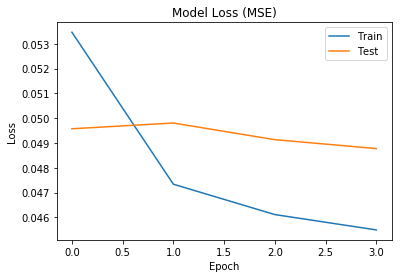

In [125]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#axes = plt.gca()
#axes.set_ylim([7500,0.2*100000])
#axes.set_xlim([1500,3000])
plt.show()

In [126]:
X1[0][0]

array([0.08259227, 0.01696887, 0.02251618, 0.0541817 , 0.        ,
       0.08110087, 0.04658413, 0.22652773, 0.06315362, 0.        ,
       0.20033807, 0.14503682, 0.09063452, 0.        , 0.        ,
       0.        , 0.08044518, 1.        , 0.20452885])

In [127]:
#history=model.fit(X, y, epochs=3000, verbose=1)
#model.evaluate(X,y)

In [128]:
X1[~msk].shape

(105, 3, 19)

In [129]:
orderlist

NameError: name 'orderlist' is not defined

In [130]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(98)

#Defining order list
orderlist=[]
for grp in cols2consider:
        orderlist=orderlist+grp

# Define a function that returns the segment if a touple in the fom (index in list,tt) is given
def tellme_seg(tu):
    return orderlist[tu[0]]

# Defining a function to map travel times to the segments
def arrange_tt_by_seg(tlist):
    touple_list=[(i,tlist[i]) for i in range(len(tlist))]
    touple_list.sort(key=tellme_seg)
    sorted_tp_list=touple_list
    arranged_tt=[el[1] for el in sorted_tp_list]
    return arranged_tt

#Function to return arranged and normalized 
def get_pdt_and_act(obs):
    
    #Reshaping input to be suitable for the observation
    x1_input = X1[~msk][obs].reshape((1, W_size, len(X1[0][0])))
    x2_input = X2[~msk][obs].reshape((1, W_size, len(X2[0][0])))
    x3_input = X3[~msk][obs].reshape((1, W_size, len(X3[0][0])))
    #x4_input = X4[~msk][obs].reshape((1, W_size, len(X4[0][0])))
    
    #Predicting values for each group for rnd observation
    g1_yp=model1.predict(x1_input, verbose=0)
    g2_yp=model2.predict(x2_input, verbose=0)
    g3_yp=model3.predict(x3_input, verbose=0)
    #g4_yp=model4.predict(x4_input, verbose=0)

    #Getting the real value for each group for the rnd
    g1_ya=y1[~msk][obs]
    g2_ya=y2[~msk][obs]
    g3_ya=y3[~msk][obs]
    #g4_ya=y4[~msk][obs]
    
    tt_list_ya=list(g1_ya)+list(g2_ya)+list(g3_ya)#+list(g4_ya)
    tt_list_yp=list(g1_yp[0])+list(g2_yp[0])+list(g3_yp[0])#+list(g4_yp[0])
    
    act=arrange_tt_by_seg(tt_list_ya)
    pdt=arrange_tt_by_seg(tt_list_yp)
    
    return pdt,act

pdt_1,act_1=get_pdt_and_act(2)

#print(type(g1_ya.shape),"\n\n")
#print(len(yhat[0]))
# pdt=yhat[0]
# act=y_output
# if len(pdt)==len(act):
#     print("Lengths match good to go!")

In [143]:
def giveme_ytest(rows,cols):
    for i in range(0,rows+1):
        print(y_test[i][:cols])
giveme_ytest(3,3)

[0.30691836 0.15728999 0.12043194]
[0.04252749 0.02675237 0.11333422]
[0.04685653 0.08948658 0.46107908]
[0.05175736 0.20648128 0.42513327]


In [132]:
act_1

[0.499837565277633,
 0.16516624509112302,
 0.22388410719284801,
 0.14348930958747902,
 0.405287170305238,
 0.23703826620976898,
 0.31222970301993397,
 0.0468565326099218,
 0.0778064228304407,
 0.43088362848993195,
 0.508069489239154,
 0.286139089552905,
 0.08948658100232801,
 0.10891653511914098,
 0.263594463027995,
 0.46107907663573794,
 0.484212239159704,
 0.532882844578684,
 0.385996199489057,
 0.52694184435113,
 0.6027589519902821,
 0.32049965550584497,
 0.47891560555522394,
 0.332559039469314,
 0.22227459190437499,
 0.0465495161177187,
 0.0406900560658761,
 0.447588699688116,
 0.5578380511827541,
 0.499606120200231,
 0.547787319763777,
 0.6330406469866441,
 0.16445803523501598,
 0.35847895959292503,
 0.420400984444807,
 0.0670986735373232,
 0.54413682989586,
 0.301534088492661,
 0.44713201845756606,
 0.477500940474216,
 0.465613995673153,
 0.496867601480515,
 0.534543979840054,
 0.3587419283162461,
 0.213393180071702,
 0.6298134237430041,
 0.164627358051427,
 0.40775741309113794,


In [133]:
# Just python refreshment
#chin=np.asarray([i for i in range(280
#chin.reshape((1,W_size,70))

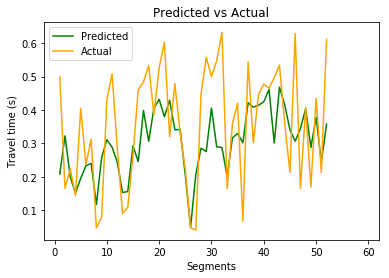

In [134]:
import matplotlib.pyplot as plt
import numpy

#Function to plot any two values:
def plot_this(predicted,actual):
    x=list(range(1,len(predicted)+1))
    plt.plot(x, predicted[0:], color='g',label="Predicted")
    plt.plot(x, actual[0:], color='orange',label="Actual")
    plt.xlabel('Segments')
    plt.ylabel('Travel time (s)')
    plt.title('Predicted vs Actual')
    axes = plt.gca()
    #axes.set_ylim([0,180])
    axes.set_xlim([-2,len(predicted)+10])
    leg = plt.legend();
    plt.show()
plot_this(pdt_1,act_1)

In [135]:
#Scaling the IO values and then determining MSE and shit
import pandas as pd

# Selecting data min-max data
Minmax = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Minmax_M1.csv')


In [136]:
# Just to eyeball data
Minmax

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52
0,499.023505,265.785819,159.995802,248.620342,101.573964,61.425238,39.343582,112.103158,139.252302,78.190117,...,63.513548,57.083218,82.654144,85.473796,60.904490,58.028471,74.351947,87.429917,57.099331,54.932805
1,26.158056,27.536591,21.152663,24.150879,19.133680,14.930106,14.523853,15.238092,18.761138,19.305581,...,26.936210,24.696562,25.155726,25.038811,21.749082,22.501708,25.270028,25.668435,22.860676,26.390242


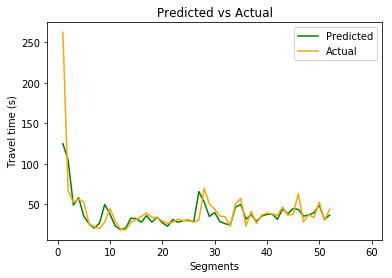

In [137]:
from sklearn.metrics import mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_pred,y_true):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# To denormalize
def denormalize_pdt_act(nor_pdt,nor_act):
    pdt_cor=[i for i in range(52)]
    act_cor=[i for i in range(52)]
    i=0
    for col in Minmax:
        mn=Minmax[col][1]
        mx=Minmax[col][0]
        pdt_cor[i]=(nor_pdt[i]*(mx - mn))+mn
        act_cor[i]=(nor_act[i]*(mx - mn))+mn
        i=i+1
    return pdt_cor,act_cor

P,A=denormalize_pdt_act(pdt_1,act_1)
plot_this(P,A)

In [138]:
import matplotlib.pyplot as plt
import numpy

#function to get errror for any pdt and act
def get_error_pdt_act(pdt_err,act_err,printing=False):
    if printing==True:
        print("MSE Error:",mean_squared_error(pdt_err,act_err))
        print("RMSE Error:",np.sqrt(mean_squared_error(pdt_err,act_err)))
        print("MAPE Error:",mean_absolute_percentage_error(pdt_err,act_err))
    mse=mean_squared_error(pdt_err,act_err)
    rmse=np.sqrt(mean_squared_error(pdt_err,act_err))
    mape=mean_absolute_percentage_error(pdt_err,act_err)
    return mse,rmse,mape

get_error_pdt_act(P,A,False) 


(465.10713624845243, 21.56634267205389, 17.448432026228843)

In [144]:
get_pdt_and_act(0)

([0.15991479,
  0.2351017,
  0.08362928,
  0.13727047,
  0.09867005,
  0.17150259,
  0.14249715,
  0.10445173,
  0.27388766,
  0.20490998,
  0.18365185,
  0.2196078,
  0.09427822,
  0.19823891,
  0.18495634,
  0.22554487,
  0.37086183,
  0.24506022,
  0.42382574,
  0.2952038,
  0.28441647,
  0.37402603,
  0.25573766,
  0.2800397,
  0.15378211,
  -0.04234936,
  0.120089665,
  0.28945827,
  0.23861958,
  0.3042963,
  0.25960708,
  0.23822598,
  0.15417103,
  0.23766452,
  0.23947841,
  0.29635876,
  0.34841928,
  0.30284718,
  0.35098615,
  0.35496694,
  0.30912685,
  0.30226535,
  0.37087628,
  0.26861084,
  0.36007917,
  0.27034336,
  0.38110447,
  0.3068546,
  0.26330537,
  0.30799168,
  0.297472,
  0.38347062],
 [0.0932564342167936,
  0.517556823056986,
  0.44849584936649106,
  0.270439937310253,
  0.30728692793467405,
  0.322095556810457,
  0.297991404450599,
  0.306918363111073,
  0.345747826973245,
  0.242043103739939,
  0.27905528897492,
  0.20795586711077302,
  0.157289990103847

In [139]:
#Iterating over all tensors in test set

#Check if lengths match:
if X1.shape[0]==y1.shape[0]==X2.shape[0]:
    print("Good to go!")
else:
    print("Lengths dont match!")

MSE_list=[]
RMSE_list=[]
MAPE_list=[]
pdt_list=[]
act_list=[]


total_test=X1[~msk].shape[0]
for ind in range(total_test):
    norm_pdt,norm_act=get_pdt_and_act(ind)
    denorm_pdt,denorm_act=denormalize_pdt_act(norm_pdt,norm_act)
    pdt_list.append(denorm_pdt)
    act_list.append(denorm_act)
    MSE_list.append(get_error_pdt_act(denorm_pdt,denorm_act)[0])
    RMSE_list.append(get_error_pdt_act(denorm_pdt,denorm_act)[1])
    MAPE_list.append(get_error_pdt_act(denorm_pdt,denorm_act)[2])

mean_MSE=sum(MSE_list)/len(MSE_list)
mean_RMSE=sum(RMSE_list)/len(RMSE_list)
mean_MAPE=sum(MAPE_list)/len(MAPE_list)    

print("\n")
print("Model - 3")

print("Overall MSE",mean_MSE)
print("Overall RMSE",mean_RMSE)
print("Overall MAPE",mean_MAPE)

Good to go!


Model - 3
Overall MSE 491.15407232139023
Overall RMSE 19.352890174724614
Overall MAPE 24.52651246807804


In [140]:
X1[~msk].shape[0]

105

In [141]:
# Creating a dataframe out of the tt lists
predicted_df=pd.DataFrame(pdt_list)
actual_df=pd.DataFrame(act_list)

In [148]:
#Saving the dataframes as csv tables.
predicted_df.to_csv("Model3_v2_pdt_M1.csv")
actual_df.to_csv("Model3_v2_act_M1.csv")

In [147]:
actual_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,70.255802,150.844104,83.423234,84.856386,44.466502,29.905981,21.919919,44.967760,60.420696,33.558177,...,43.913925,37.427791,37.100481,39.490220,25.053877,33.714356,41.142581,48.501632,34.896893,42.231998
1,39.951394,60.410631,29.176375,32.452984,31.884294,16.945760,15.631771,19.357521,56.665448,35.359529,...,51.235791,38.086942,35.072994,61.473903,26.701777,34.249752,27.457488,56.234090,25.210251,31.089346
2,262.513971,66.887321,52.237435,56.359847,52.545670,25.951231,22.273310,19.776853,28.136124,44.677964,...,46.488406,36.315013,37.425496,63.101576,28.195134,36.988009,33.554430,52.553410,30.136825,43.855478
3,32.499265,42.965826,34.029578,39.416149,22.627864,16.540112,16.320643,20.251573,107.900813,31.646596,...,43.596371,26.434305,25.898109,45.278987,27.044471,26.258946,26.399141,50.368279,23.918845,31.909896
4,199.270804,116.962582,70.848275,27.747010,34.300028,16.772044,14.920776,17.945427,36.156730,38.343374,...,43.524175,40.962290,34.081728,54.251380,33.587512,37.062353,37.071576,57.280089,37.958162,40.187483
5,32.637660,33.324788,34.408364,26.622519,26.076189,16.516394,15.578747,16.685449,33.909129,19.305581,...,53.381748,38.115552,58.424413,28.174478,25.421343,33.888955,41.744206,46.178652,27.549174,34.788513
6,39.633088,105.637667,30.662357,35.862962,27.985694,18.613205,15.790551,34.747985,45.250529,29.792785,...,49.856001,26.977879,62.052520,33.708289,26.026069,27.743550,39.152685,41.942536,31.896376,45.999899
7,123.082340,137.505428,104.394282,39.003306,65.307446,42.065560,25.622234,26.372990,29.600545,30.801305,...,37.951607,41.702763,32.999870,43.337191,33.613263,32.212764,46.726668,43.617350,36.445687,43.214177
8,44.141763,85.403974,35.640885,94.507706,36.891904,26.049389,20.079398,32.788494,75.695083,30.535321,...,40.008297,31.791893,53.170725,56.259214,32.318718,32.553688,43.429488,34.256496,31.748941,40.981495
9,499.023505,127.283273,101.509978,32.399653,39.914489,27.069645,28.745016,31.384297,37.868663,44.969634,...,51.383100,29.213189,68.861191,33.818771,27.110964,38.044772,30.243225,58.132023,25.372437,43.899264
